In [14]:
#Comparing Search Algorithms - Directed Evolution
#Disease Biophysics Group
#Written by John Zimmerman
#Updated 10/25/23

import os
import tensorflow as tf
import numpy as np
from itertools import product
import pandas as pd
import scipy.interpolate
import scipy.stats
import math
from matplotlib.pyplot import *
%matplotlib inline
import h5py
import GeoSwimmer
import statsmodels.api as sm

In [4]:
class SwimSearch:
    def seededList(df):
        alphabet = SwimDNA.DNABasis()
        seedlist=  np.array([])
        for a in alphabet[1:-1]:
            seedlist = np.append(seedlist,(a*6))
            seedlist = np.append(seedlist,a+alphabet[0]*5)
            seedlist = np.append(seedlist,a+alphabet[-1]*5)
        
        seed = pd.DataFrame({'DNA':seedlist})
        seed = df[df.DNA.isin(seed.DNA)]
        
        return seed

In [5]:
class SwimDNA:
    def getWeights(DNA):
        weights = np.ones(len(DNA))
        m = -1/float(len(DNA))
        b = 1
        for i in range(0,len(DNA)):
            weights[i] = m*i+b
        weights = weights/np.sum(weights)
        return weights

    def string_to_matrix(string):
        matrix = np.zeros((14,len(string)), dtype=np.int8)
        for position, letter in enumerate(string):
            num = (ord(letter.upper()) - 65) % 14
            matrix[num, position] = 1
        return matrix

    def DNABasis():
        return ['A','B','C','D','E','F','G','H','I','J','K','L','M','N']
    
    def avgDnaListDistance(dnalist):
        #Feed in dataframe.DNA list
        avglist = np.zeros(dnalist.size) #Declare List for storing Averages

        for DNA1,i in zip(dnalist,np.arange(dnalist.size)): #Cycled through each DNA
            dist = 0
            for DNA2 in dnalist: #Compare to Each Other DNA in database
                if DNA1 != DNA2:
                    dist += SwimDNA.dnaDistance(DNA1,DNA2)
            dist = dist/float(dnalist.size-1) #Average Out Values
            avglist[i] = dist
        return avglist

    def dnaDistance(DNA1,DNA2):
        vector1 = SwimDNA.DNAVector(DNA1)
        vector2 = SwimDNA.DNAVector(DNA2)
        dist = 0
        for a in SwimDNA.DNABasis():
            dist += (vector1[a]-vector2[a])**2

        return np.sqrt(dist)

    def DNAVector(DNA):
        weights = SwimDNA.getWeights(DNA)
        vector = {a:0 for a in SwimDNA.DNABasis()}
        num = np.arange(len(DNA))

        for a,i in zip(DNA,num):
                    vector[a]+=1*weights[i]
        return vector


In [6]:
class NN:
    
    def OneHotEncodeList (SwimList):
        trainMatrix  =np.zeros((SwimList.DNA.size,14,len(SwimList.DNA.iloc[0])))

        i=0
        for DNA in SwimList.DNA:
            trainMatrix[i,:,:] = SwimDNA.string_to_matrix(DNA)
            i+=1

        trainMatrix= tf.convert_to_tensor(trainMatrix,dtype=tf.float16)    
        return trainMatrix

    def LabelTensor (SwimList):
        labelMatrix  =np.zeros(SwimList.Label.size)

        i=0
        for DNA in SwimList.DNA:
            trainMatrix[i,:,:] = SwimDNA.string_to_matrix(DNA)
            i+=1

        trainMatrix= tf.convert_to_tensor(trainMatrix,dtype=tf.float32)    
        return trainMatrix

    def genNNModel(InputLength):
        model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(14, InputLength)),
          tf.keras.layers.Dense(14, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(14*14, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(14, activation='relu'),
          tf.keras.layers.Dense(1,activation='sigmoid')
        ])
        return model
   
    def genNN_MatMul_model(InputLength):# define two sets of inputs
        inputA = tf.keras.Input(shape=(14,InputLength))

        # Dense Input Branch - Make a 14 dim vector
        x = tf.keras.layers.Flatten()(inputA)
        x = tf.keras.layers.Dense(14, activation="relu")(x)
        x = tf.keras.layers.Reshape((14, 1))(x)
        #x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.Model(inputs=inputA, outputs=x)
        
        #Build cross-correlation Matrix
        y = tf.keras.layers.Flatten()(inputA)
        y = tf.keras.layers.Dense(14*14, activation="relu")(y)
        y = tf.keras.layers.Reshape((14, 14))(y)
        #x = tf.keras.layers.BatchNormalization()(x)
        y = tf.keras.Model(inputs=inputA, outputs=y)

        
        #combine the output of the two branches
        combined = tf.linalg.matmul(y.output, x.output)

        # Combined Outputs
        z = tf.keras.layers.Flatten()(combined)
        z = tf.keras.layers.Dense(14, activation="relu")(z)
        z = tf.keras.layers.Dropout(0.2)(z)
        z = tf.keras.layers.Dense(6, activation="relu")(z)
        z = tf.keras.layers.Dense(1, activation="sigmoid")(z)


        #Combined model outputs join of branches
        model = tf.keras.models.Model(inputs=[inputA], outputs=z)
        return model


    def genNN_mixed_model(InputLength):# define two sets of inputs
        inputA = tf.keras.Input(shape=(14,InputLength))

        # Dense Input Branch
        x = tf.keras.layers.Flatten()(inputA)
        x = tf.keras.layers.Dense(14, activation="relu")(x)
        #x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.Model(inputs=inputA, outputs=x)
        
        #inputB = tf.reshape(inputA,(-1,14,InputLength,1))
        # the second branch opreates on the second input
        y = tf.keras.layers.Reshape((-1, -1, 1))(inputA)
        y = tf.keras.layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(y)
        y = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')(y)
        #y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.Dropout(0.2)(y)
        y = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(y)
        y = tf.keras.layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(y)
        #y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.Dropout(0.2)(y)
        y = tf.keras.layers.Reshape((14, InputLength))(inputA)
        y = tf.keras.layers.Flatten()(y)
        y = tf.keras.layers.Dense(14, activation="relu")(y)
        #y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.Model(inputs=inputA, outputs=y)
        
        #combine the output of the two branches
        combined = tf.keras.layers.add([x.output, y.output])
        #combined = tf.keras.layers.concatenate([x.output, y.output])

        # Combined Outputs
        z = tf.keras.layers.Flatten()(combined)
        z = tf.keras.layers.Dense(14, activation="relu")(z)
        z = tf.keras.layers.Dropout(0.2)(z)
        z = tf.keras.layers.Dense(6, activation="relu")(z)
        z = tf.keras.layers.Dense(1, activation="sigmoid")(z)


        #Combined model outputs join of branches
        model = tf.keras.models.Model(inputs=[inputA], outputs=z)
        return model
    
    def genNNModelLim(InputLength):
        tf.keras.backend.set_floatx('float64')
        model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(14, InputLength)),
          tf.keras.layers.Dense(14, activation='relu'),
          tf.keras.layers.Dropout(0.1),
          #tf.keras.layers.Dense(32, activation='relu'),
          #tf.keras.layers.Dropout(0.1),
          tf.keras.layers.Dense(14, activation='relu'),
          tf.keras.layers.Dropout(0.1),
          #tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(14, activation='relu'),
          tf.keras.layers.Dense(1,activation='sigmoid')
        ])
        return model
    
    def NNOptimizer(lr=0.001,epsilon=1e-07,amsgrad=False):
        return tf.keras.optimizers.Adam(learning_rate=lr, epsilon=epsilon, amsgrad=amsgrad, name='Adam')
    
    def cum_KL_divergence(ge_c,ge_mean,ge_sigma):
        def KL_div(cdf_pred, cdf_true):
            P = NN.TF_pdf(NN.TF_ppf(cdf_pred,ge_c,ge_mean,ge_sigma),ge_c,ge_mean,ge_sigma) #CDF -> PDF
            Q = NN.TF_pdf(NN.TF_ppf(cdf_true,ge_c,ge_mean,ge_sigma),ge_c,ge_mean,ge_sigma)  #CDF -> PDF
            P = tf.where(tf.math.is_nan(P),tf.convert_to_tensor(0.000001,dtype=tf.float64),P)
            Q = tf.where(tf.math.is_nan(Q),tf.convert_to_tensor(0.000001,dtype=tf.float64),Q)

            return tf.math.square(cdf_pred-cdf_true)#+P*tf.math.log(P/Q)
        return KL_div

    
    def TF_ppf(q,c,mean,sigma):
        x=-tf.math.log(-tf.math.log(q))
        
        return tf.where((c == 0) & (x == x),x,-tf.math.expm1(-c *x )/c)*sigma+mean
    
    def TF_pdf(x,c,mean,sigma):
        z = (x-mean)/sigma
        return tf.where((c==0),tf.math.exp(z)*tf.math.exp(-1*tf.math.exp(z)),tf.math.exp(-(1-c*z)**(1/c))*(1-c*z)**(1/c-1))*(1/sigma)

In [7]:
def Evaluate(truth,label):
    return np.sqrt((truth-label)**2).sum()

In [8]:
def InitializeTraining(df,initialNumber,seed):
    train = SwimSearch.seededList(df) #Seed with some selected basis functions (BAAAAA,BNNNNN,BAAAAA)
    remain = initialNumber-train.DNA.size
    train = train.append(df[~df.DNA.isin(train.DNA)].sample(remain,random_state=seed))
    return train

In [9]:
def Evaluate_NumSeq(num_sequence, target, df):
    #print(num_sequence)
    DNA = SequenceToDNA(num_sequence)
    print(DNA)
    label = df[df.DNA==DNA].Label.to_list()[0]
    return np.sqrt((target-label)**2)

def Evaluate_DNA(DNA, target, df):
    print(DNA)
    label = df[df.DNA==DNA].Label.to_list()[0]
    return np.sqrt((target-label)**2)

def DNA_ToArray(DNA):
    seq = np.zeros(len(DNA))
    for (letter,i) in zip(DNA,range(0,len(DNA))):
        seq[i] = ord(letter)-65
    return seq
        
def SequenceToDNA(seq):
    int_seq = np.rint(seq)
    string = ''
    for i in int_seq:
        string += chr(65+int(i))
    return string

def Eval_top_predicted(evaluated_DF, dataframe,num=2000):
    topLabel = dataframe.nlargest(num,"Label")
    #topModel = dataframe.nlargest(num,"ModelLabel")
    correct = evaluated_DF[evaluated_DF.DNA.isin(topLabel.DNA)==True].DNA.size
    print(f'correct: {correct}')
    return correct

#DNA_ToArray('NGGGGG')

In [16]:
def GenFooDataframe(dnaLength):
    #---Make Swimmer Dataframe with Foo Velocity Labels ---
    #Takes ~15 min to run
    print('Generating Foo dataframe. Takes ~15 min')
    #Generate List of all possible swimmers
    dnaAlphabet = SwimDNA.DNABasis()
    fullswimlist = [''.join(i) for i in product(dnaAlphabet, repeat = dnaLength)]
    fullswimlist = fullswimlist[1:-1]
    df = pd.DataFrame({'DNA':fullswimlist})

    #SampleSwim = Swimlist.sample(100000,random_state=seed)
    print('Label Velocities...')
    dfLabels = df.DNA.apply(SwimVel.gen_approx_swim_vels, args=(.5,0.0,0.0,0,.05)) 
    print('Done')

    alphabetVectors = RadarPlot.constructRadarBasis(SwimDNA.DNABasis())
    print('Radar Points...')
    RadarPoints = df.DNA.apply(RadarPlot.DNARadarPointsList, args=(alphabetVectors,))
    RadarPoints = pd.DataFrame(RadarPoints.to_list(),columns=['RadX','RadY'])
    print('Done')

    df['RadX']=RadarPoints.RadX.to_list()
    df['RadY']=RadarPoints.RadY.to_list()
    df['Label'] = dfLabels
    return df

class SwimVel:
    def gen_approx_swim_vels(DNA,syn1mag=0.5,syn2mag=0.5,syn3mag=0.5,syn4mag=0.5,syn5mag=0.25):
        swimVels = SwimVel.approx_dna_to_vel_base(DNA)+SwimVel.approx_dna_to_vel_syn5(DNA,syn5mag)+SwimVel.approx_dna_to_vel_syn1(DNA,syn1mag)+SwimVel.approx_dna_to_vel_syn2(DNA,syn2mag)+SwimVel.approx_dna_to_vel_syn3(DNA,syn3mag)+SwimVel.approx_dna_to_vel_syn4(DNA,syn4mag)
        return swimVels
    
    def approx_dna_to_vel_base(DNA):
        val = 0
        weights = SwimDNA.getWeights(DNA)
        for a,wgt in zip(DNA,weights):
            val = val + np.sin((float(ord(a)-65)/13.)*4*np.pi+np.pi*5/4)*wgt
        return val
    
    def approx_dna_to_vel_syn1(DNA, mag=0.5):
        #adds value for streaks (JKLMN)
        val = 0
        if mag !=0:
            weights = SwimDNA.getWeights(DNA)
            i=0
            for a in DNA:
                if i>0:
                    if (ord(a)-ord(DNA[i-1])!=0):
                        val = val + ((13-np.abs(ord(a)-ord(DNA[i-1])))/13)*weights[i]
                        #val = val + mag*(1-weights[i])
                i+=1
        return val*mag

    def approx_dna_to_vel_syn2(DNA, mag=0.5):
        #Subtracts value for negative streaks (NMLKJ)
        val = 0
        if mag !=0:
            weights = SwimDNA.getWeights(DNA)
            i=0
            for a in DNA:
                if i>0:
                    if (ord(a)-ord(DNA[i-1])==-1):
                        val = val - mag*weights[i]
                i+=1
        return val
    
    def approx_dna_to_vel_syn3(DNA, mag=0.5):
        #Multiples Weights from first half with second half - rev order
        weights = SwimDNA.getWeights(DNA)
        chr_values = np.zeros(len(DNA))
        if mag !=0:
            i = 0
            for a,wgt in zip(DNA,weights):
                chr_values[i] =  ((13-float(ord(a)-65))/13.)*wgt
                i+=1
        
        return np.sin(chr_values.reshape(2,-1).prod(axis=0)*10).sum()*mag    
    
    def approx_dna_to_vel_syn4(DNA, mag=0.5):
        #Adds value for middle charcter interactions
        weights = SwimDNA.getWeights(DNA)
        characters = np.zeros(len(DNA))
        if mag !=0:
            i=0
            for a, w in zip(DNA, weights):
                characters[i] = float(ord(a) - 65)
                i += 1
            weights[:2] = 0
            weights[-2:] = 0
        return np.dot(characters, weights).sum()*mag

    def approx_dna_to_vel_syn5(DNA, mag=0.25):
        #Random depending on repeat charcters
        counts = {a:0 for a in SwimDNA.DNABasis()}
        val = 1
        if mag !=0:
            for a in DNA:
                counts[a]+=1
            for k,v in counts.items():
                if (v == 1):
                    val +=1
                elif (v > 1):
                    val -= v/5
        return val*mag

In [17]:
def CheckRemainder(train,evaluated_list,df,targetDNA,genNum,repeatcount=0,repeatlimit=6*14-1):
    remainder = train[train.DNA.isin(evaluated_list.DNA)]
    
    if(repeatcount>=repeatlimit):
        #Checks if all mutations to a single DNA have been attempted. Then iterates down the list
        sort = evaluated_list.nlargest(evaluated_list.shape[0],"Label")
        sort = sort.reset_index()
        cur_index = sort[sort.DNA == targetDNA].index[0]
        targetDNA = sort.iloc[cur_index+1].DNA
        repeatcount = 0
    
    if(remainder.shape[0]>0):
        print('Looping - '+str(repeatcount))
        newsDNA = GeoSwimmer.GeoSwimmer.GenerateSwimArray(targetDNA,remainder.shape[0],genNum+repeatcount,6,EvolveDNA=True,insert_del=False,double=False)
        added = pd.DataFrame({'DNA':newsDNA})
        added = df[df.DNA.isin(added.DNA)]
        
        train = train[~train.DNA.isin(evaluated_list.DNA)]
        train = train.append(added)
        train = CheckRemainder(train,evaluated_list,df,targetDNA,genNum,repeatcount=repeatcount+1)
    return train
    

def DE_TrainLoop(savepath,loadpath, seed=12345, InitialNumbers=400,loops=10,simsperloop=50, save=False):
    initial_list = InitializeTraining(df,InitialNumbers,seed)
    #initial_list = InitializeTraining(df,41,10)
    evaluated_list = initial_list.copy()
    Eval_top_predicted(evaluated_list,df,2000)
    evaluated_list['Gen'] = -1
  
    if save:
        print('TestSave')
        evaluated_list.to_pickle(savepath+'DE_Results_'+str(seed)+'.pkl',)
    
    
    Predicted = np.array([])
    train = evaluated_list.copy();
    
    for generation in range(loops):
        print(f'Generation: {generation}')
        
        #Directed Evolution
        targetDNA = train.nlargest(1,"Label").DNA.to_numpy()[0]
        newsDNA = GeoSwimmer.GeoSwimmer.GenerateSwimArray(targetDNA,simsperloop,generation,6,EvolveDNA=True,insert_del=False,double=False)
        train = pd.DataFrame({'DNA':newsDNA})
        train = df[df.DNA.isin(train.DNA)]
        
        #makes sure that it is new sDNA sequences
        train = CheckRemainder(train,evaluated_list,df,targetDNA,generation)
        train['Gen'] = generation

        
        evaluated_list = evaluated_list.append(train)
        correct = Eval_top_predicted(evaluated_list,df,2000)
        Predicted = np.append(Predicted,correct)
        
        if save:
            print('Saving')
            evaluated_list.to_pickle(savepath+'DE_Results_'+str(seed)+'.pkl')
            np.savetxt(savepath+'DE_predicted_'+str(seed)+'.txt',Predicted)
    
    return evaluated_list

In [18]:
#Run An Example Training Model

InitialtrainNum = 400#400
loops = 8+1 #Plus 1 to hit full Amount of 800 Swimmers
simsperloop = 50#50
save = True

seedlist = [1009,1013,1019,1021,1031,1033,1039,1049,1051,1061] #First 10 prime numbers with 4 digits


In [ ]:
loadpath = 'G:\\...\\'
savepath = 'G:\\...\\'
#e.g. 'G:\\Data Process\\NeuralNet\\EvaluationMethods\\'

loadcheck = os.path.exists(loadpath+'results.pkl')
if loadcheck == True:
    df = pd.read_pickle(loadpath+'results.pkl')
    print('Results loaded')
else:
    df = GenFooDataframe(6)
    df.to_pickle(loadpath+'results.pkl')

dnaLength = len(df.DNA[0])

correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 0
Saving
Generation: 1
Looping - 0
Looping - 1
correct: 2
Saving
Generation: 2
Looping - 0
Looping - 1
correct: 5
Saving
Generation: 3
Looping - 0
Looping - 1
correct: 7
Saving
Generation: 4
Looping - 0
correct: 11
Saving
Generation: 5
Looping - 0
Looping - 1
correct: 15
Saving
Generation: 6
Looping - 0
correct: 15
Saving
Generation: 7
Looping - 0
Looping - 1
correct: 17
Saving
Generation: 8
Looping - 0
correct: 20
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0
Looping - 0
correct: 1
Saving
Generation: 1
Looping - 0
correct: 6
Saving
Generation: 2
Looping - 0
Looping - 1
correct: 14
Saving
Generation: 3
Looping - 0
Looping - 1
correct: 21
Saving
Generation: 4
Looping - 0
Looping - 1
correct: 22
Saving
Generation: 5
Looping - 0
Looping - 1
Looping - 2
Looping - 3
correct: 29
Saving
Generation: 6
Looping - 0
Looping - 1
correct: 33
Saving
Generation: 7
Looping - 0
Looping - 1
correct: 36
Saving
Generation: 8
Looping - 0
correct: 39
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 0
Saving
Generation: 1
Looping - 0
correct: 1
Saving
Generation: 2
Looping - 0
Looping - 1
correct: 10
Saving
Generation: 3
Looping - 0
Looping - 1
correct: 18
Saving
Generation: 4
Looping - 0
correct: 22
Saving
Generation: 5
Looping - 0
correct: 24
Saving
Generation: 6
Looping - 0
Looping - 1
correct: 27
Saving
Generation: 7
Looping - 0
Looping - 1
correct: 28
Saving
Generation: 8
Looping - 0
correct: 31
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 3
Saving
Generation: 1
Looping - 0
Looping - 1
correct: 8
Saving
Generation: 2
Looping - 0
correct: 12
Saving
Generation: 3
Looping - 0
Looping - 1
Looping - 2
correct: 16
Saving
Generation: 4


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 20
Saving
Generation: 5
Looping - 0
Looping - 1
correct: 26
Saving
Generation: 6
Looping - 0
correct: 34
Saving
Generation: 7
Looping - 0
correct: 36
Saving
Generation: 8
Looping - 0
correct: 38
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 1
Saving
Generation: 1
Looping - 0
correct: 6
Saving
Generation: 2
Looping - 0
correct: 10
Saving
Generation: 3
Looping - 0
Looping - 1
correct: 13
Saving
Generation: 4
Looping - 0
Looping - 1
correct: 19
Saving
Generation: 5
Looping - 0
Looping - 1
correct: 28
Saving
Generation: 6
Looping - 0
Looping - 1
Looping - 2
Looping - 3
correct: 33
Saving
Generation: 7
Looping - 0
Looping - 1
correct: 35
Saving
Generation: 8
Looping - 0
correct: 42
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 1
Saving
Generation: 1
Looping - 0
Looping - 1
correct: 2
Saving
Generation: 2
Looping - 0
Looping - 1
correct: 4
Saving
Generation: 3
Looping - 0
correct: 10
Saving
Generation: 4
Looping - 0
Looping - 1
correct: 16
Saving
Generation: 5
Looping - 0
correct: 19
Saving
Generation: 6
Looping - 0
correct: 24
Saving
Generation: 7
Looping - 0
correct: 28
Saving
Generation: 8
Looping - 0
Looping - 1
correct: 28
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 1
Saving
Generation: 1
Looping - 0
correct: 8
Saving
Generation: 2
Looping - 0
correct: 14
Saving
Generation: 3
Looping - 0
correct: 16
Saving
Generation: 4
Looping - 0
Looping - 1
correct: 21
Saving
Generation: 5
Looping - 0
Looping - 1
correct: 31
Saving
Generation: 6
Looping - 0
correct: 32
Saving
Generation: 7
Looping - 0
correct: 34
Saving
Generation: 8
Looping - 0
correct: 38
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 3
Saving
Generation: 1
Looping - 0
correct: 10
Saving
Generation: 2
Looping - 0
Looping - 1
correct: 12
Saving
Generation: 3
Looping - 0
Looping - 1
correct: 22
Saving
Generation: 4
Looping - 0
correct: 30
Saving
Generation: 5
Looping - 0
Looping - 1
Looping - 2
correct: 34
Saving
Generation: 6
Looping - 0
Looping - 1
correct: 43
Saving
Generation: 7
Looping - 0
Looping - 1
Looping - 2
correct: 54
Saving
Generation: 8
Looping - 0
Looping - 1
correct: 64
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 1
Saving
Generation: 1
Looping - 0
Looping - 1
correct: 7
Saving
Generation: 2
Looping - 0
correct: 15
Saving
Generation: 3
Looping - 0
Looping - 1
correct: 19
Saving
Generation: 4
Looping - 0
Looping - 1
correct: 24
Saving
Generation: 5
Looping - 0
Looping - 1
correct: 36
Saving
Generation: 6
Looping - 0
Looping - 1
correct: 36
Saving
Generation: 7
Looping - 0
correct: 39
Saving
Generation: 8
Looping - 0
Looping - 1
correct: 40
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


correct: 0
TestSave
Generation: 0


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 1
Saving
Generation: 1


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


correct: 3
Saving
Generation: 2
Looping - 0
correct: 4
Saving
Generation: 3
Looping - 0
Looping - 1
correct: 5
Saving
Generation: 4
Looping - 0
Looping - 1
correct: 5
Saving
Generation: 5
Looping - 0
correct: 9
Saving
Generation: 6
Looping - 0
correct: 17
Saving
Generation: 7
Looping - 0
correct: 25
Saving
Generation: 8
Looping - 0
Looping - 1
correct: 30
Saving
Evaluated:850


C:\Users\Wyss User\.conda\envs\TF_LBM\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


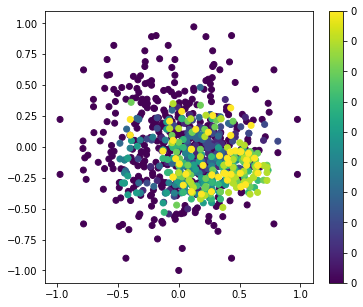

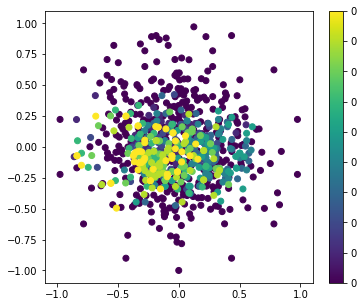

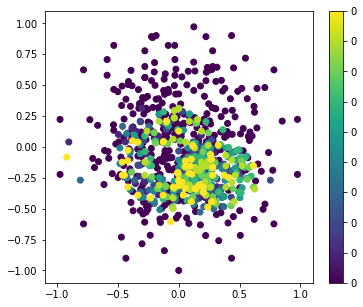

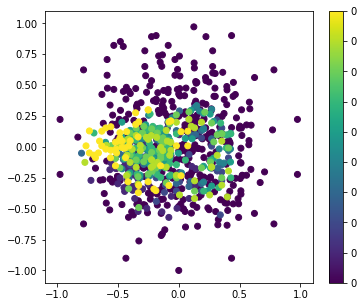

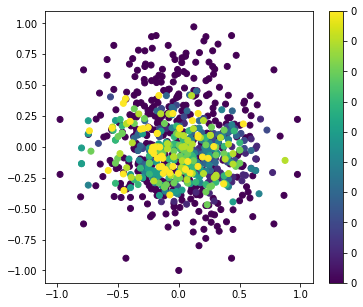

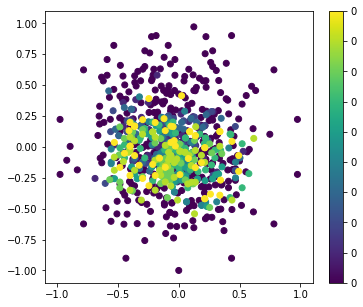

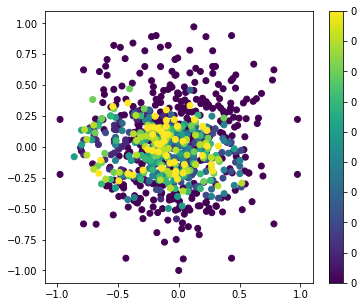

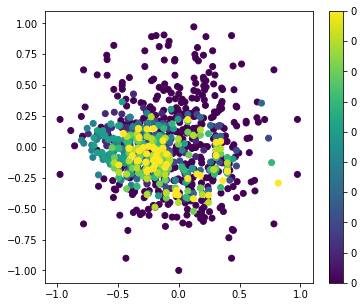

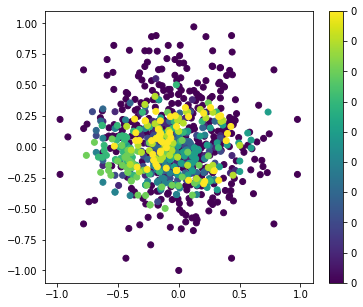

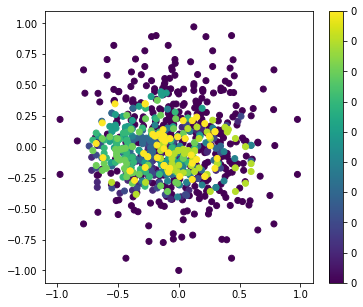

In [12]:

for seednum in seedlist:
    evalList = DE_TrainLoop(savepath,loadpath, seed=seednum, InitialNumbers=InitialtrainNum,loops=loops,simsperloop=simsperloop, save=save)
    print('Evaluated:' + str(evalList.shape[0]))
    
    #Graphing
    DF_name = 'DE_Results_'+str(seednum)
    m = evalList.Gen.to_numpy()
    m = m+1
    fig = figure(figsize=(6,5))
    scatter(evalList.RadX.to_list(),evalList.RadY.to_list(),c=m)
    cb = colorbar()
    cb.set_ticklabels(m)
    xlim(-1.1,1.1)
    ylim(-1.1,1.1)
    savefig(savepath+DF_name+'.svg',format='svg')